Backpack Prediction Challenge

2025 Kaggle Playground-Predict the price of backpacks given various attributes

Table of contents:
1. Setup
2. Exploratory analysis
3. Data cleaning
4. Feature engineering
5. Modeling
6. An ensemble model

Setup

Imports

In [2]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Local modules.
%load_ext autoreload
%autoreload 2

Load Data

In [3]:
train1 = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
train3 = pd.read_csv('data/Noisy_Student_Bag_Price_Prediction_Dataset.csv')
test = pd.read_csv('data/test.csv')
train_test = pd.concat([train1, test])

In [4]:
train1.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Exploratory analysis

In [5]:
print('Numerical columns:')
display(train1.describe(include=np.number))
print('Numerical columns:')
display(train1.describe(exclude=np.number))
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test')
], axis=1))

Numerical columns:


,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


Numerical columns:


,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,290295,291653,293405,292556,292950,292030,290050
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,60077,79630,101906,148342,148077,100031,51690


Missing Values:


,train,test
Brand,9705.0,6227.0
Material,8347.0,5613.0
Size,6595.0,4381.0
Compartments,0.0,0.0
Laptop Compartment,7444.0,4962.0
Waterproof,7050.0,4811.0
Style,7970.0,5153.0
Color,9950.0,6785.0
Weight Capacity (kg),138.0,77.0
Price,0.0,NaN


Data includes 10 columns
Simple categocial values:waterproof, size, laptop compartment, 
Discrete values: compartments
Continuous values: weight capacity, price
More complex values: brand, material, style, colors

compartments and price dont have any missing values but everything else does

In [6]:
print(train1.columns)

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')


Simple categorical values

18:57:04 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:57:04 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


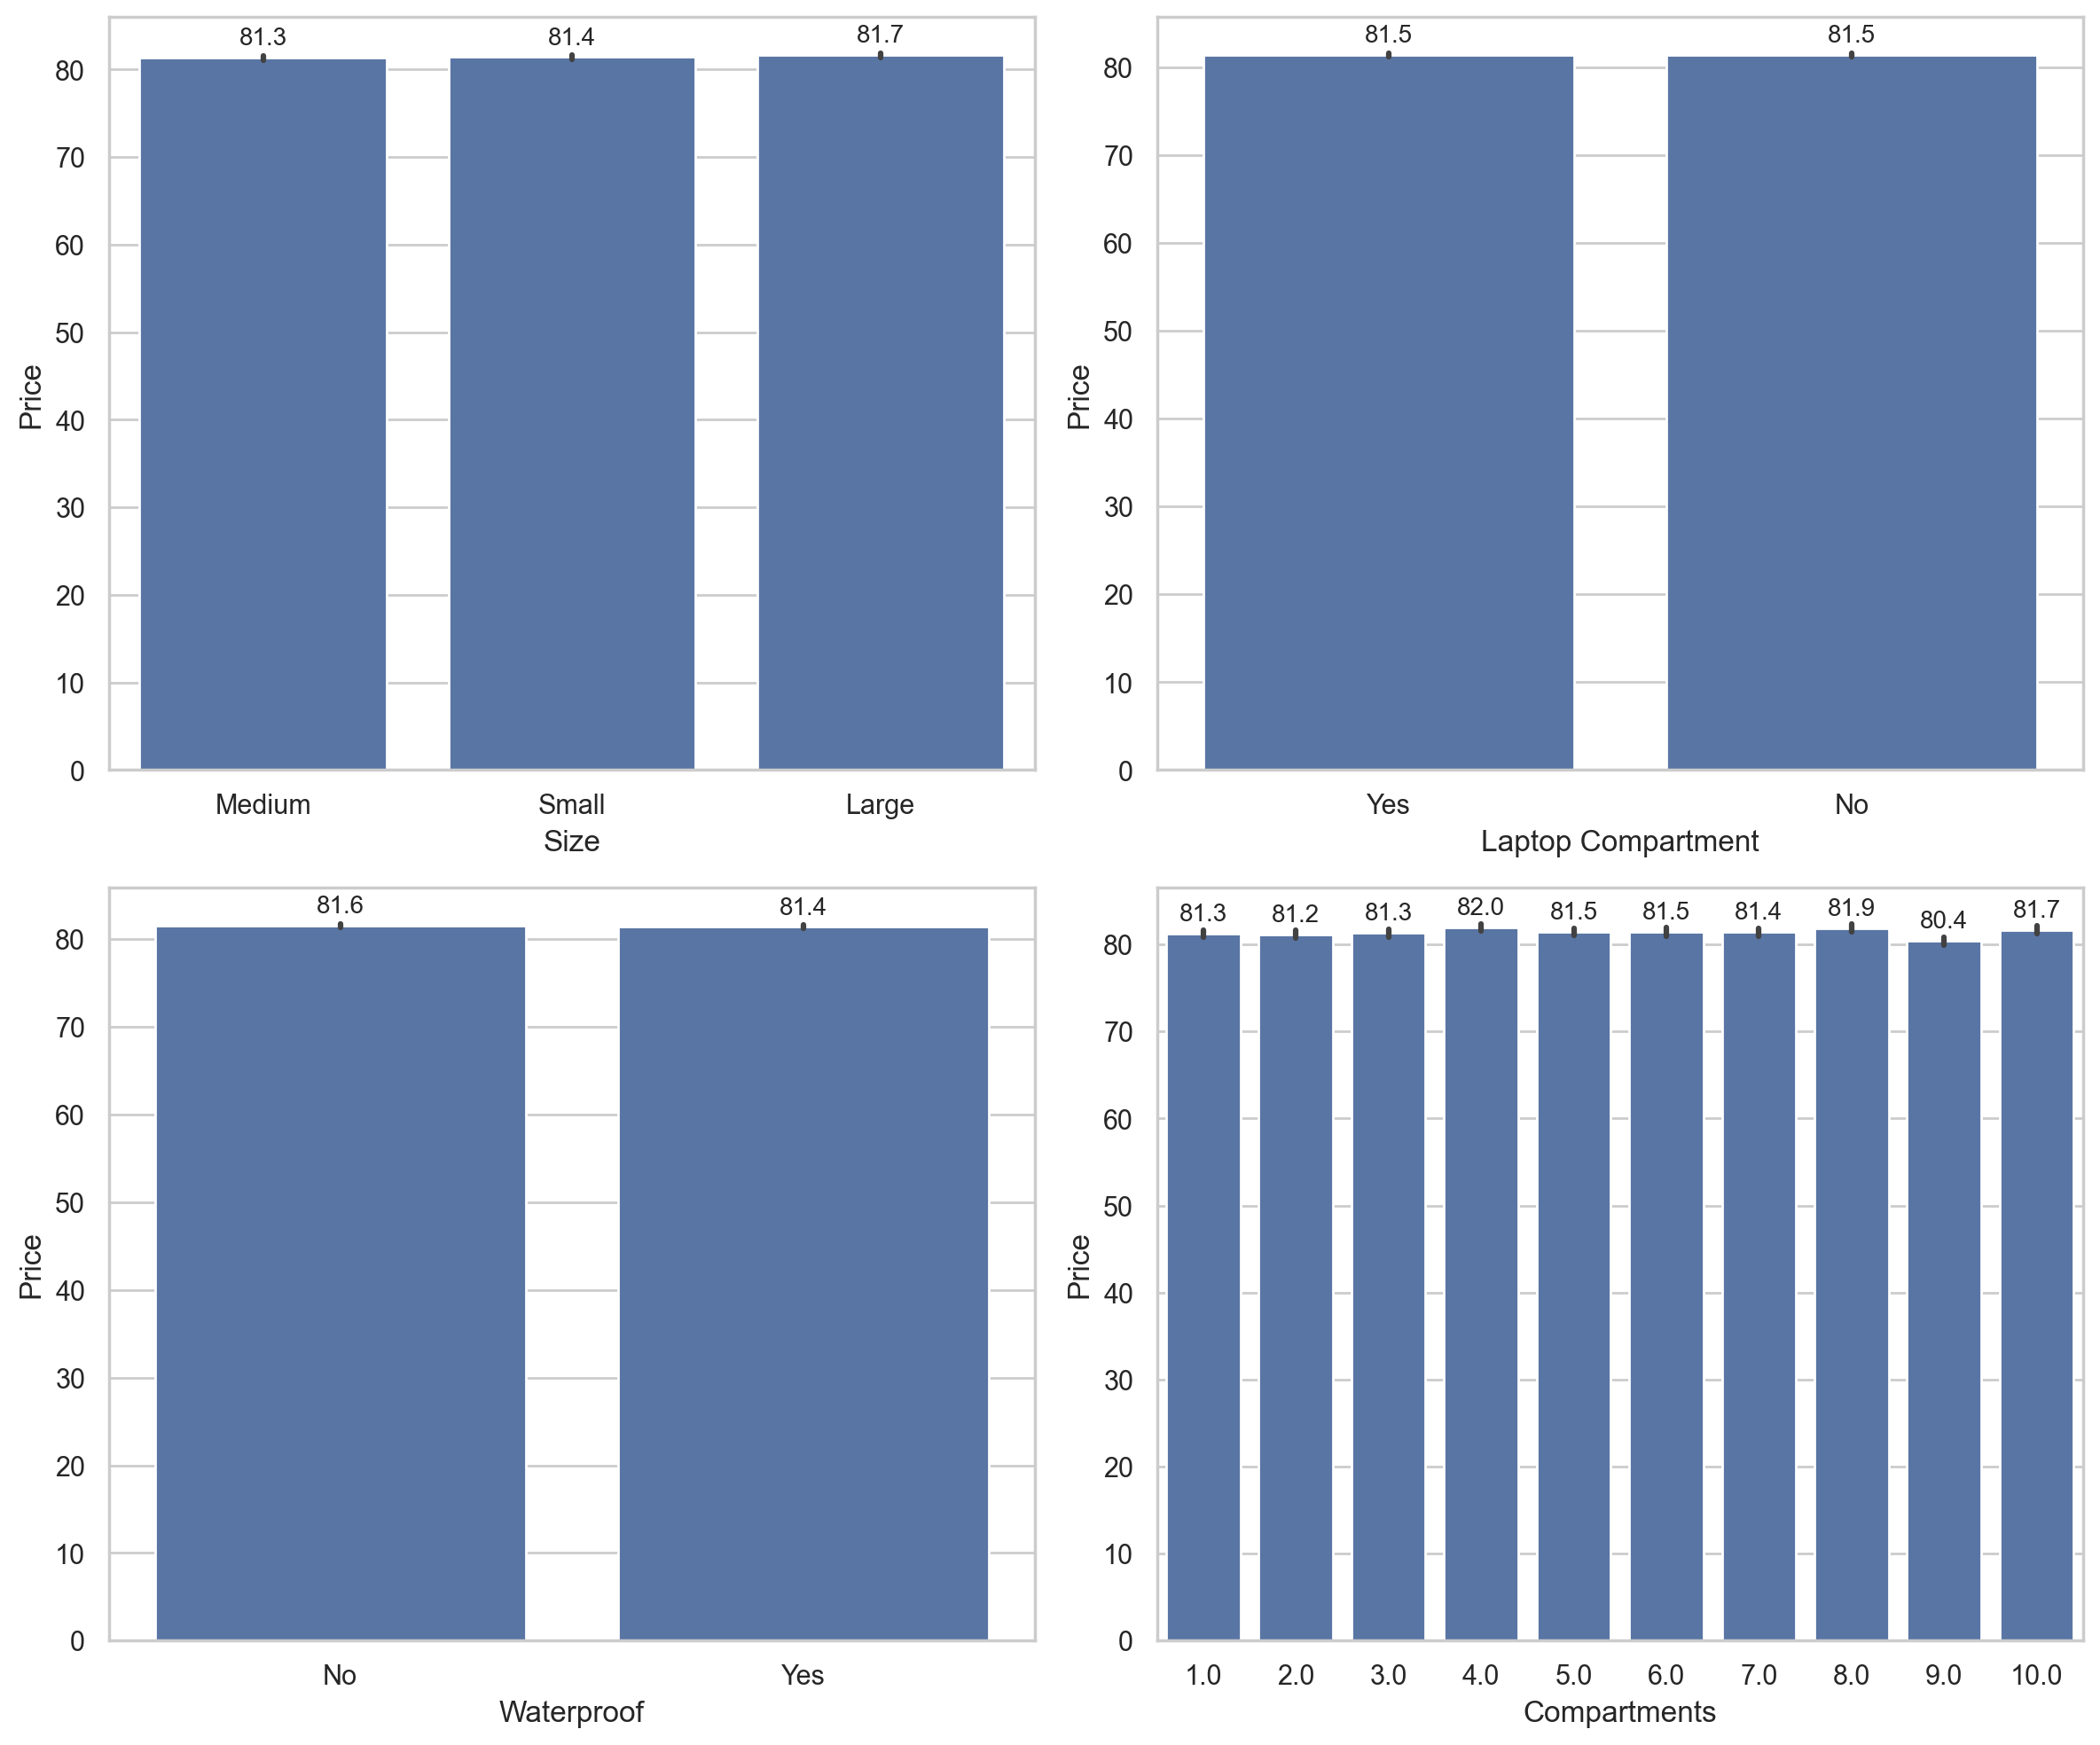

In [7]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

Large packs seem to cost a little more than both small and medium which makes sense as more material is needed to create them.
Laptop compartment does not seem to be indivative of cost
Non waterproof backpacks seem to cost more than waterproof backpacks. Could be a product of designer or nicer backpacks costing more than utility.
Number of compartments: 4 compartments seem to have the highest cost, followed closely by 8 compartments, then 10, 5/6, 7, 3, 2, 1, 9

18:59:13 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:59:15 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


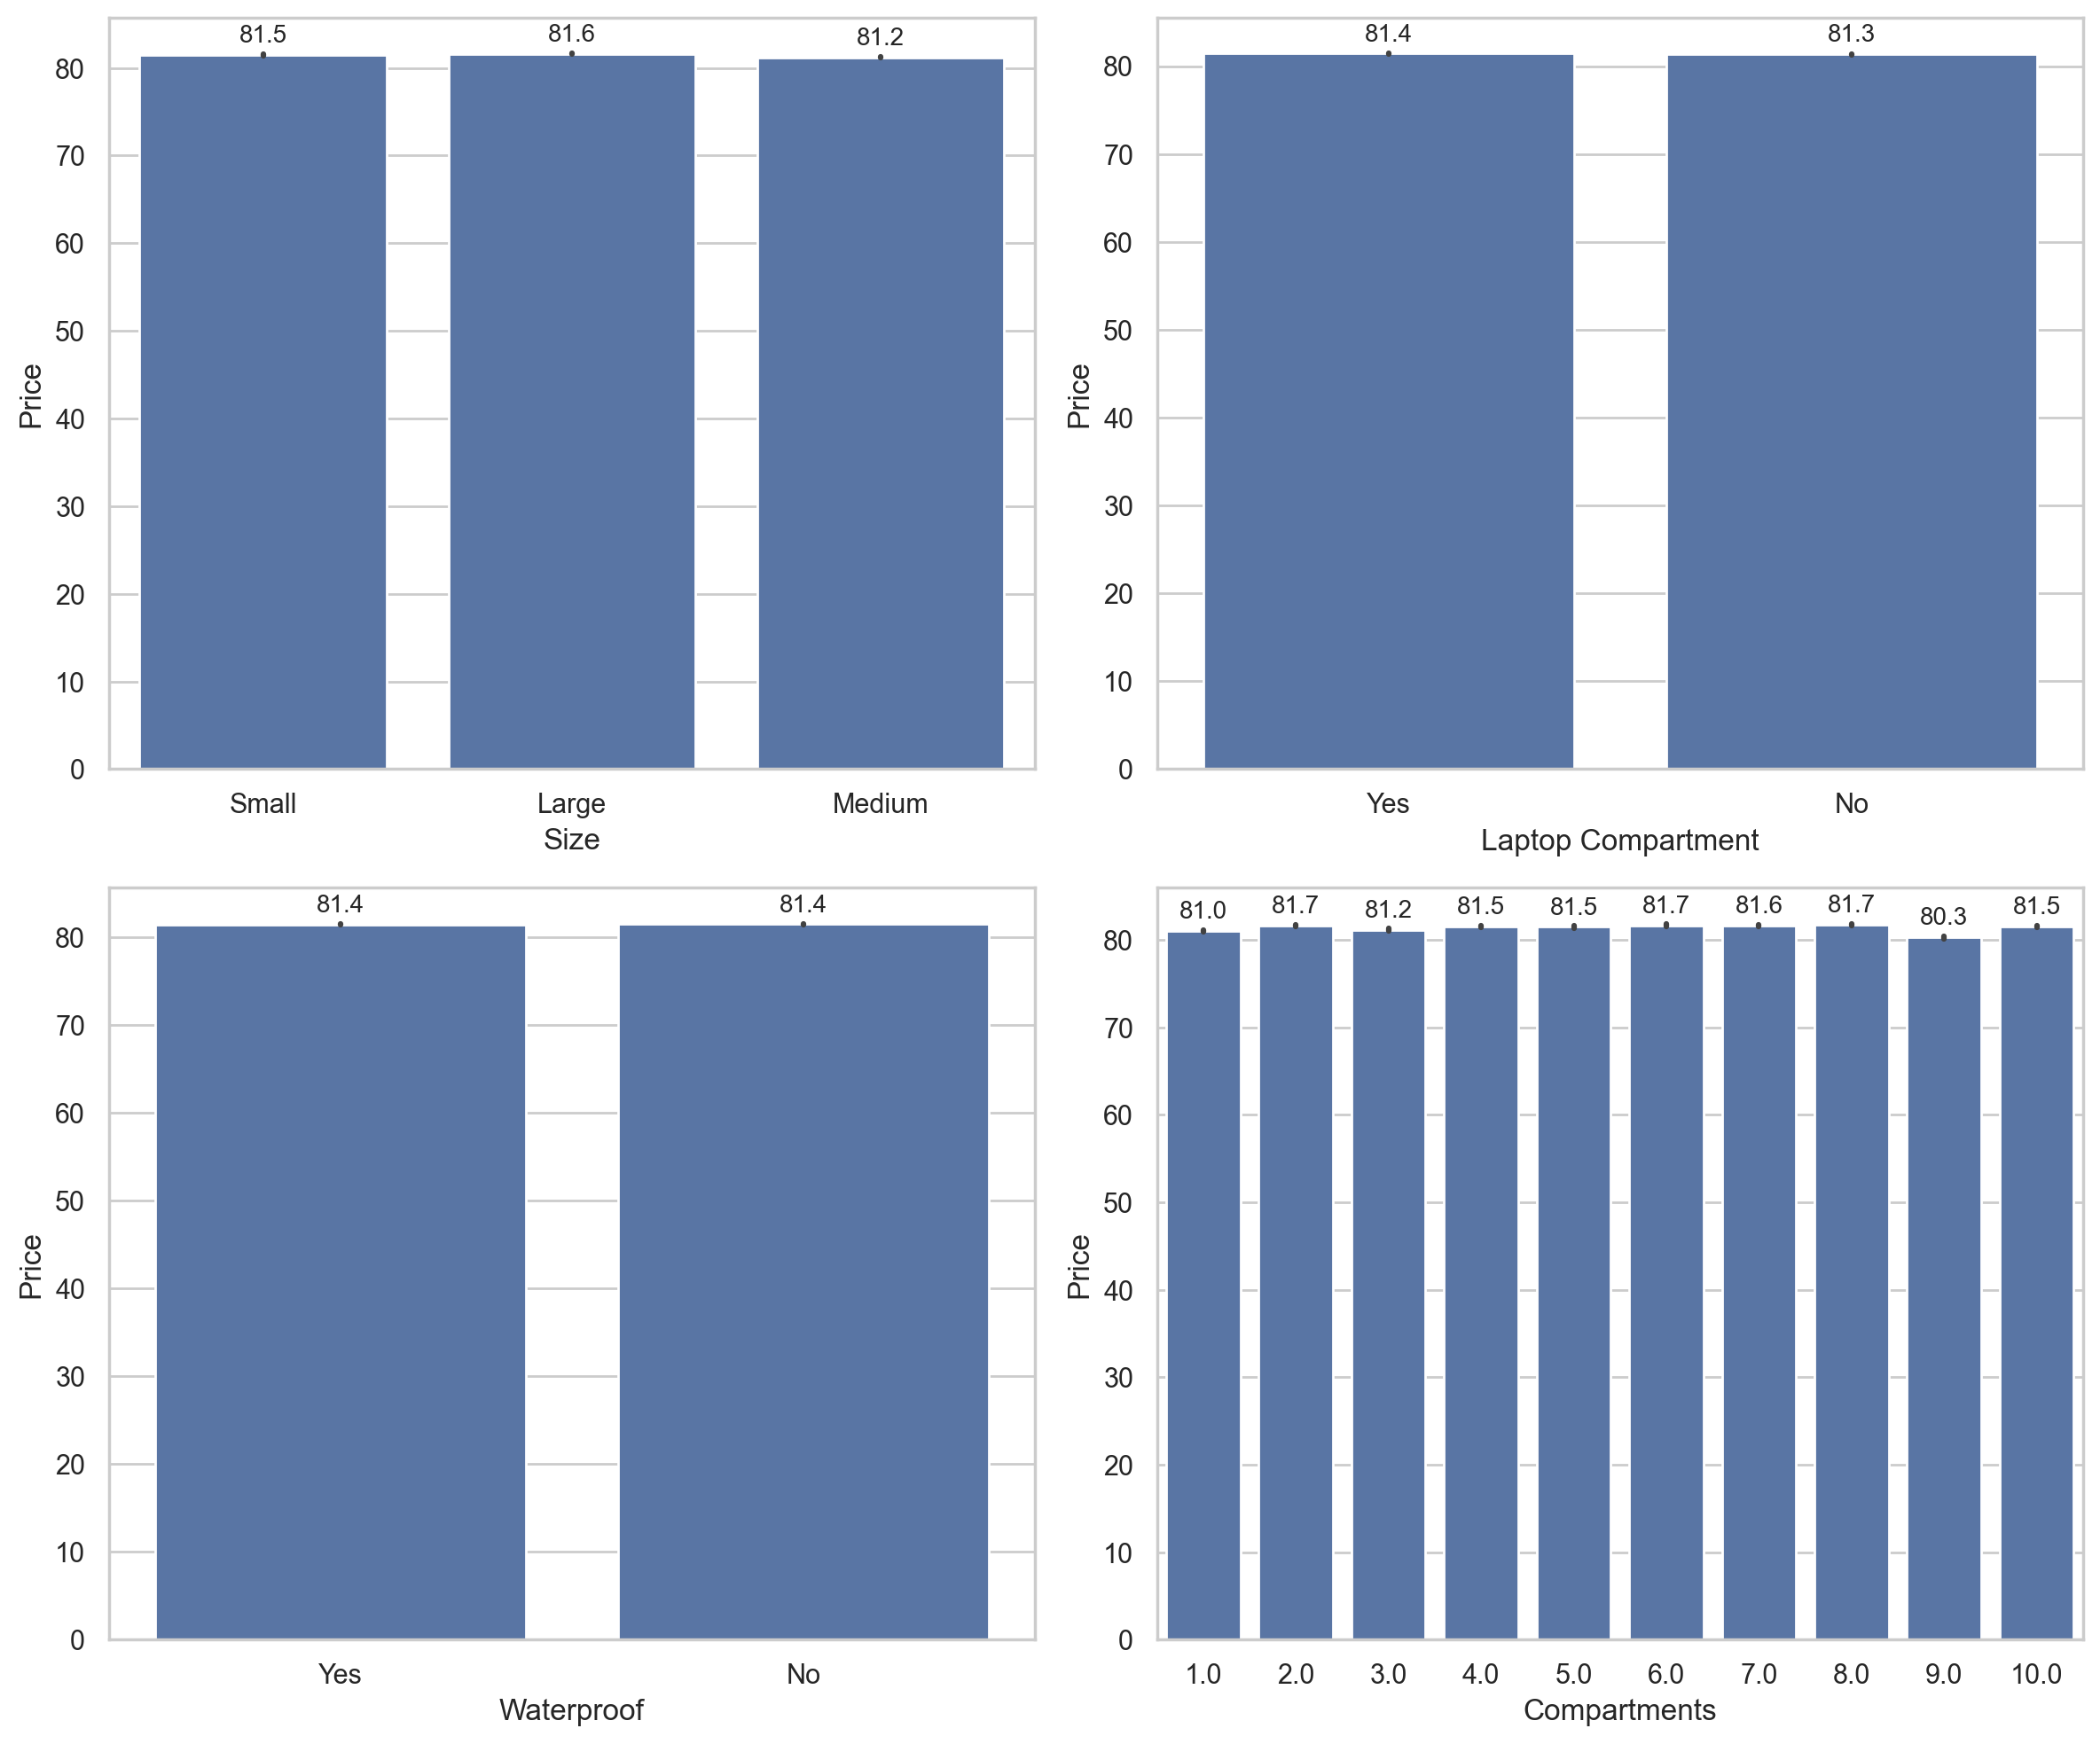

In [8]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train2, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

Number 2 training set of data shows similar results to training set 1 of data.
Large packs still cost the most out of all teh sizes.
Having a laptop compartment may increase price slightly.
Waterproof does not seem to have any impact on price.
2,4,5,6,7,8,10 seem to cost the most


18:59:45 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:59:45 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


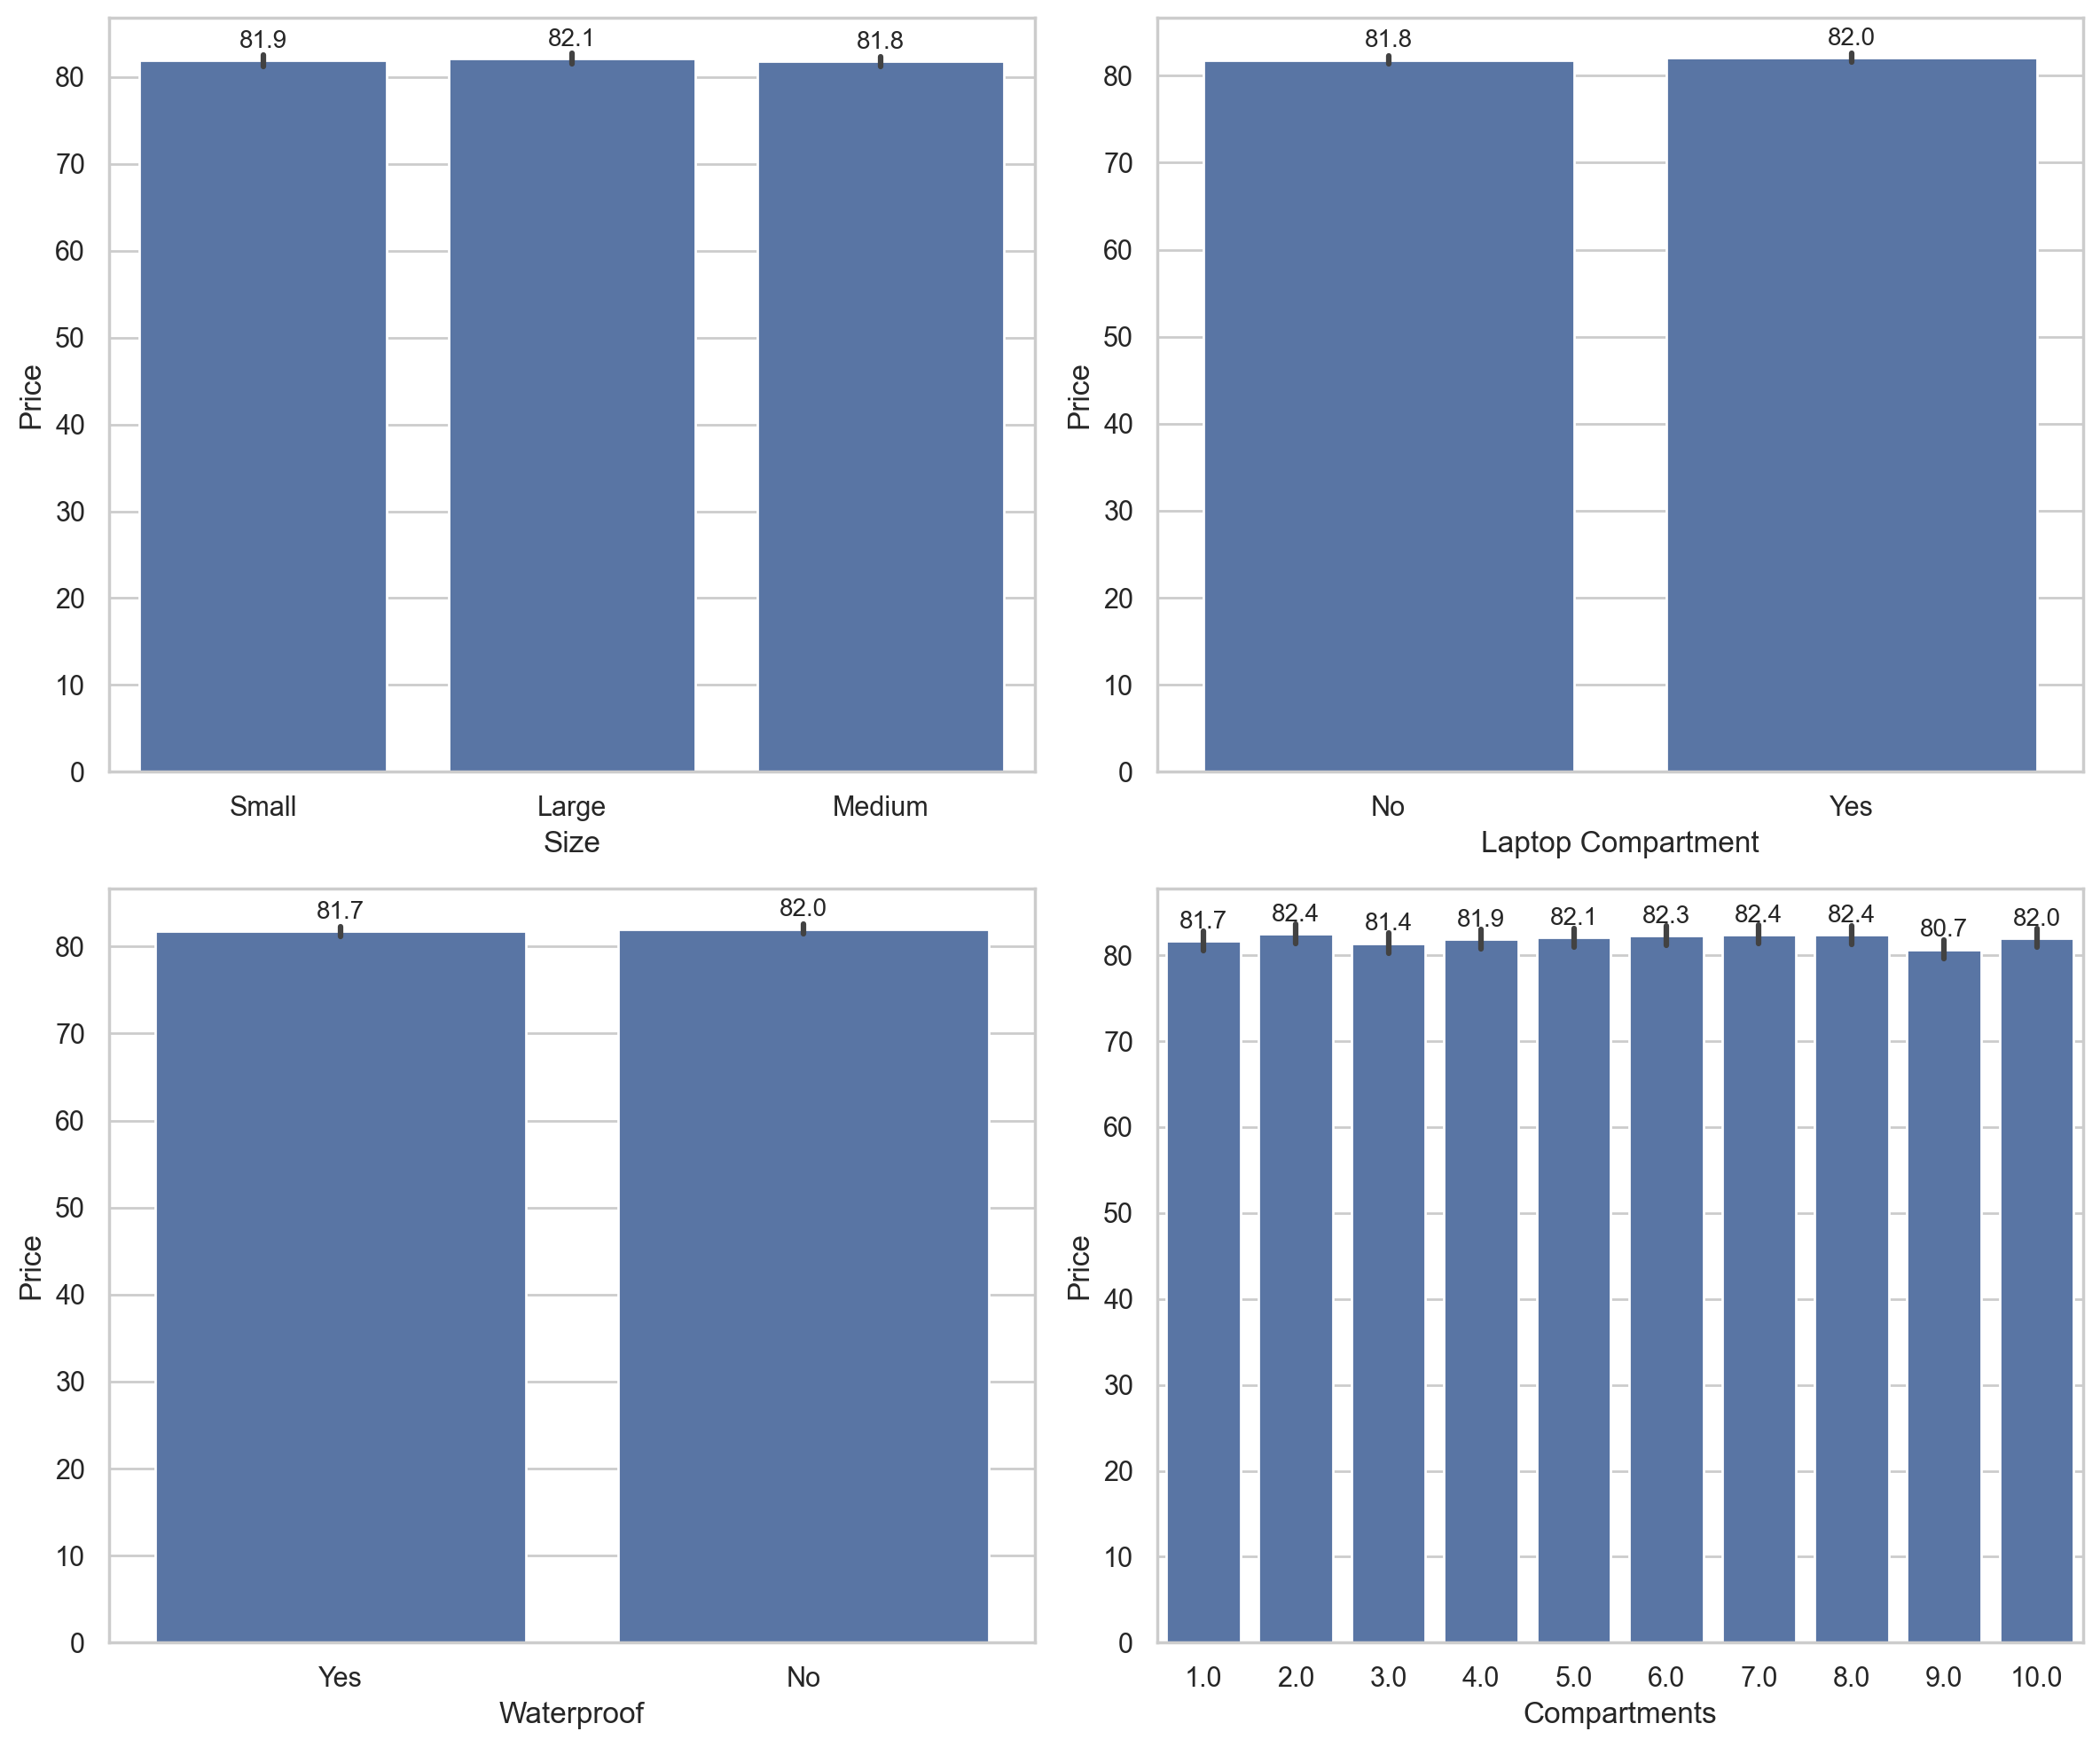

In [9]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train3, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

Training set of data number 3 shares similar patterns with both set 1 and set 2.
Large packs cost more.
Having a laptop compartment increases price.
Non waterproof increases the price
9 compartments continues to have the lowest price for all 3 training groups. 

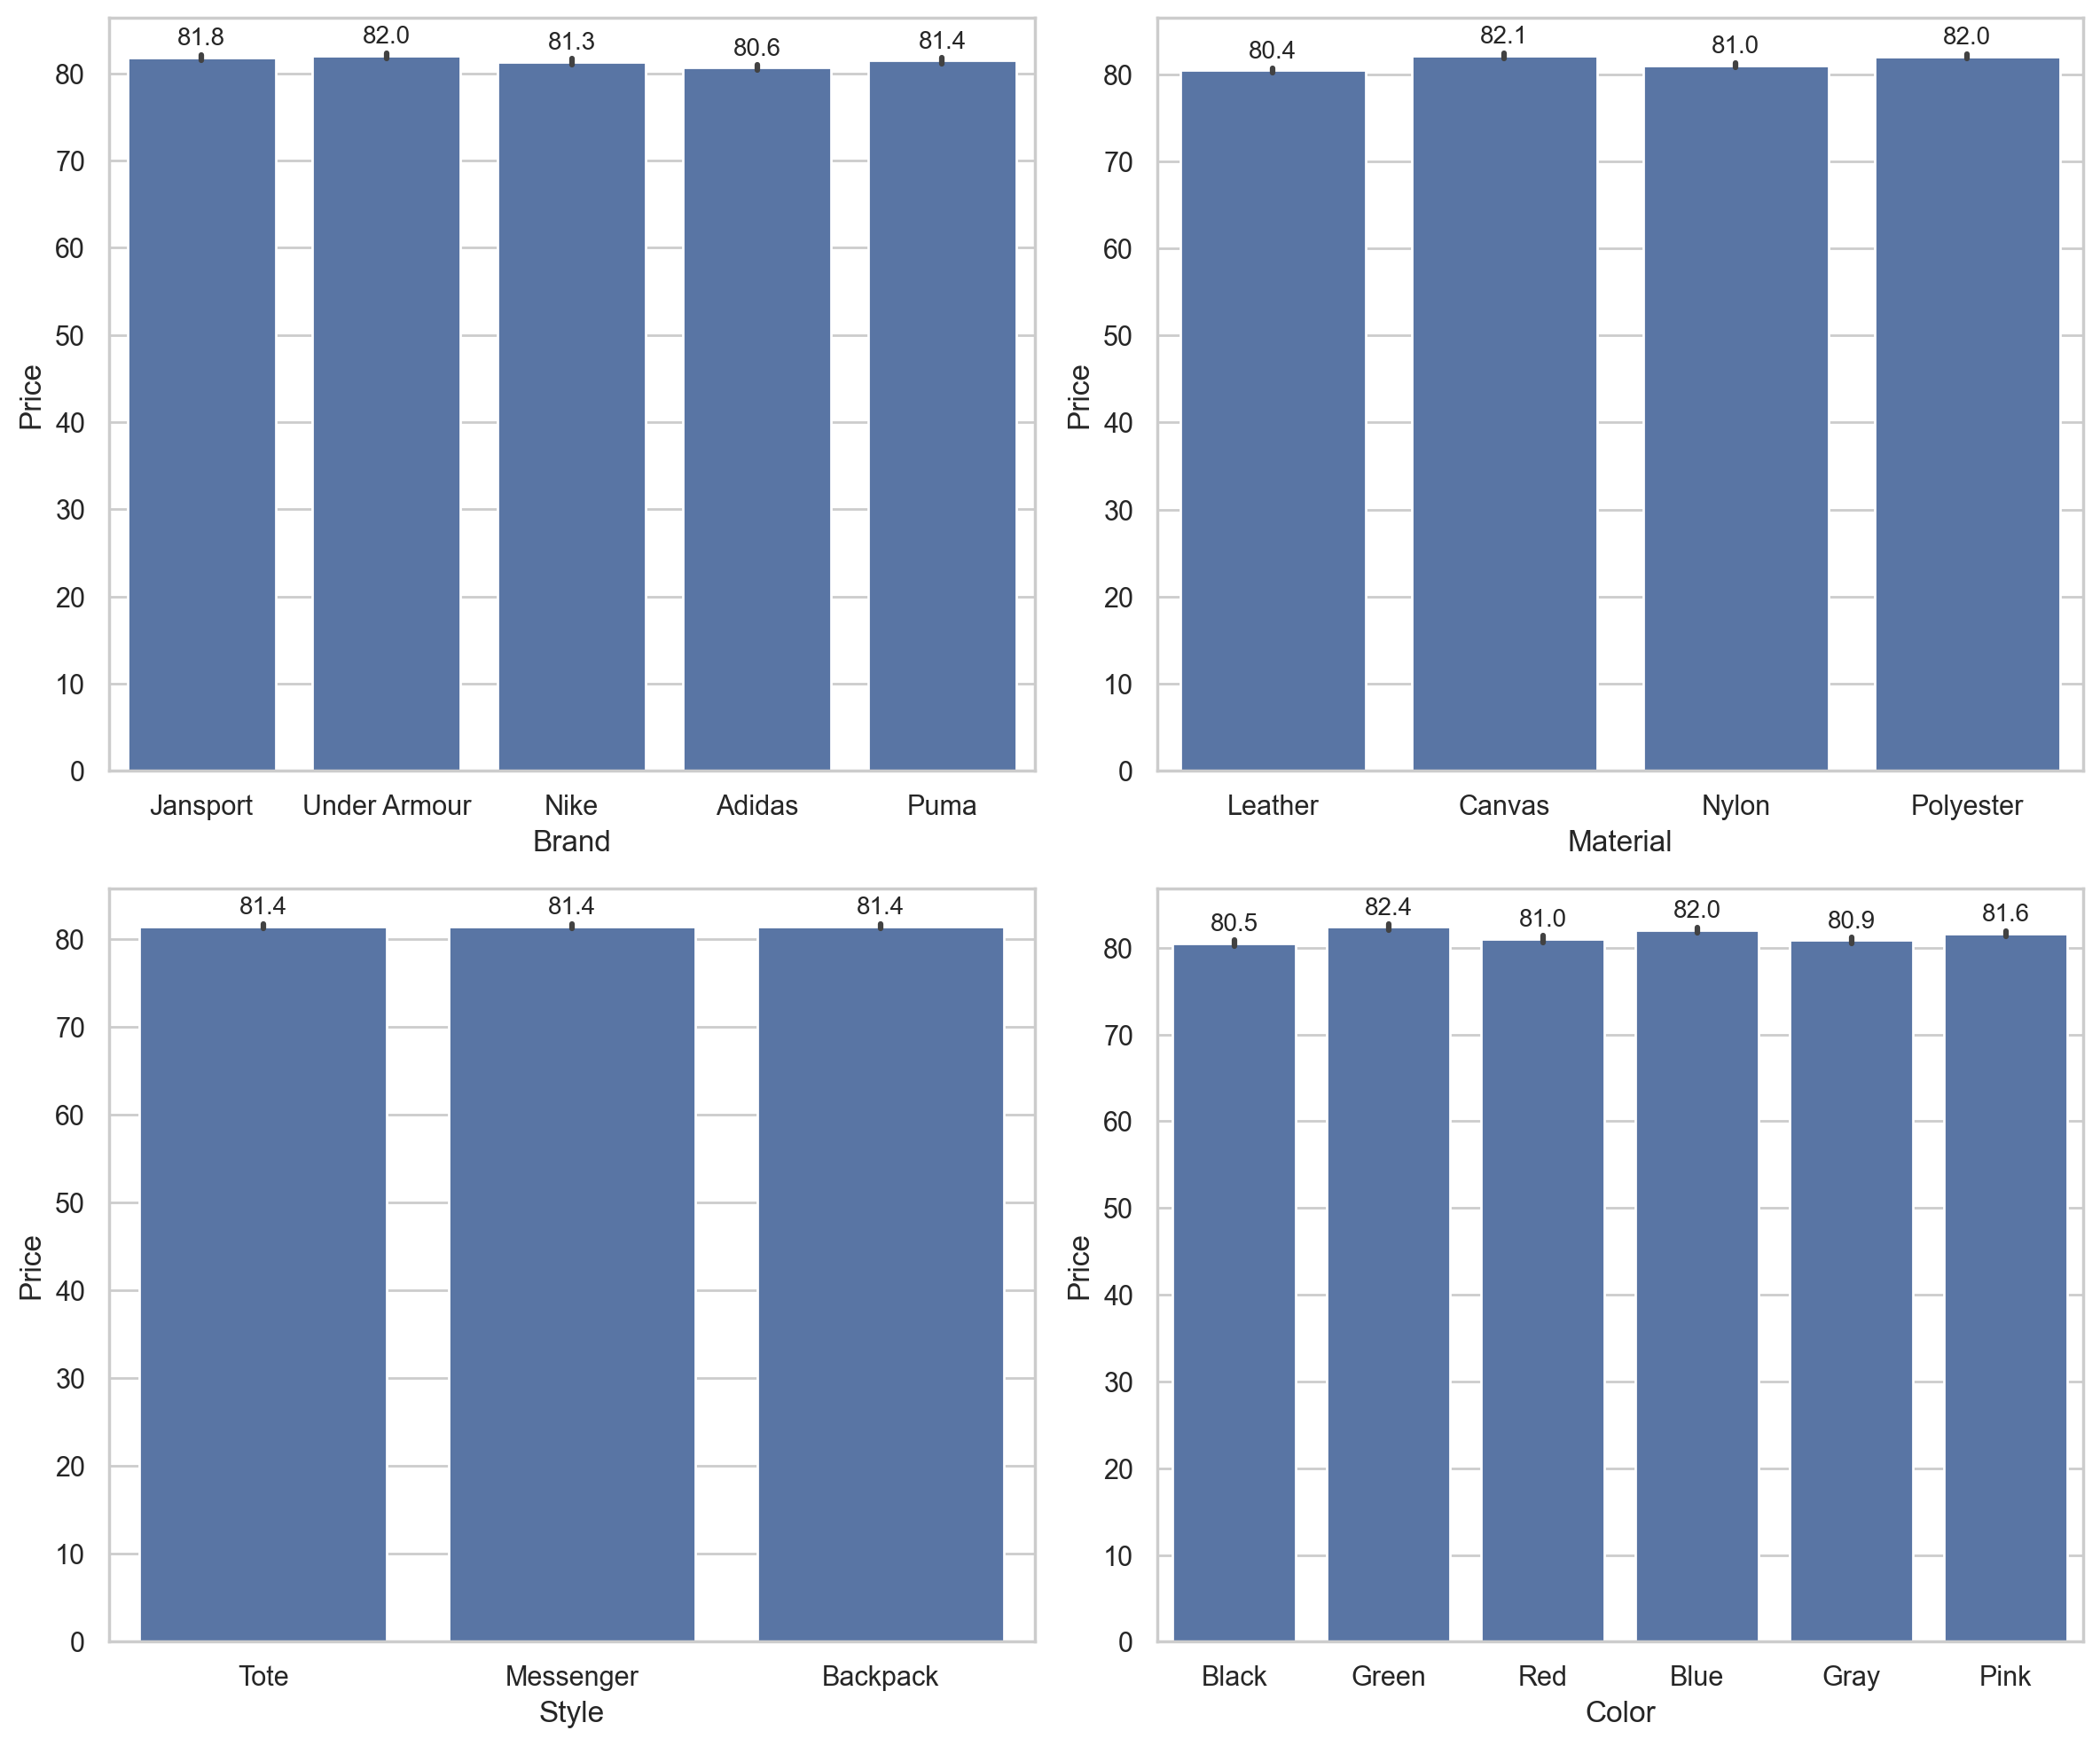

In [10]:
categorical_columns = ['Brand', 'Material', 'Style', 'Color']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax=axes[row, col]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

Under Armour and Jansport have the most expensive packs while Adidas has the least expensive packs.
Canvas and Polyester have the most expensive packs, Leather is the least expersive.
Style of bag does not impact price.
Green and blue backpacks tend to cost the most while black packs cost the less.

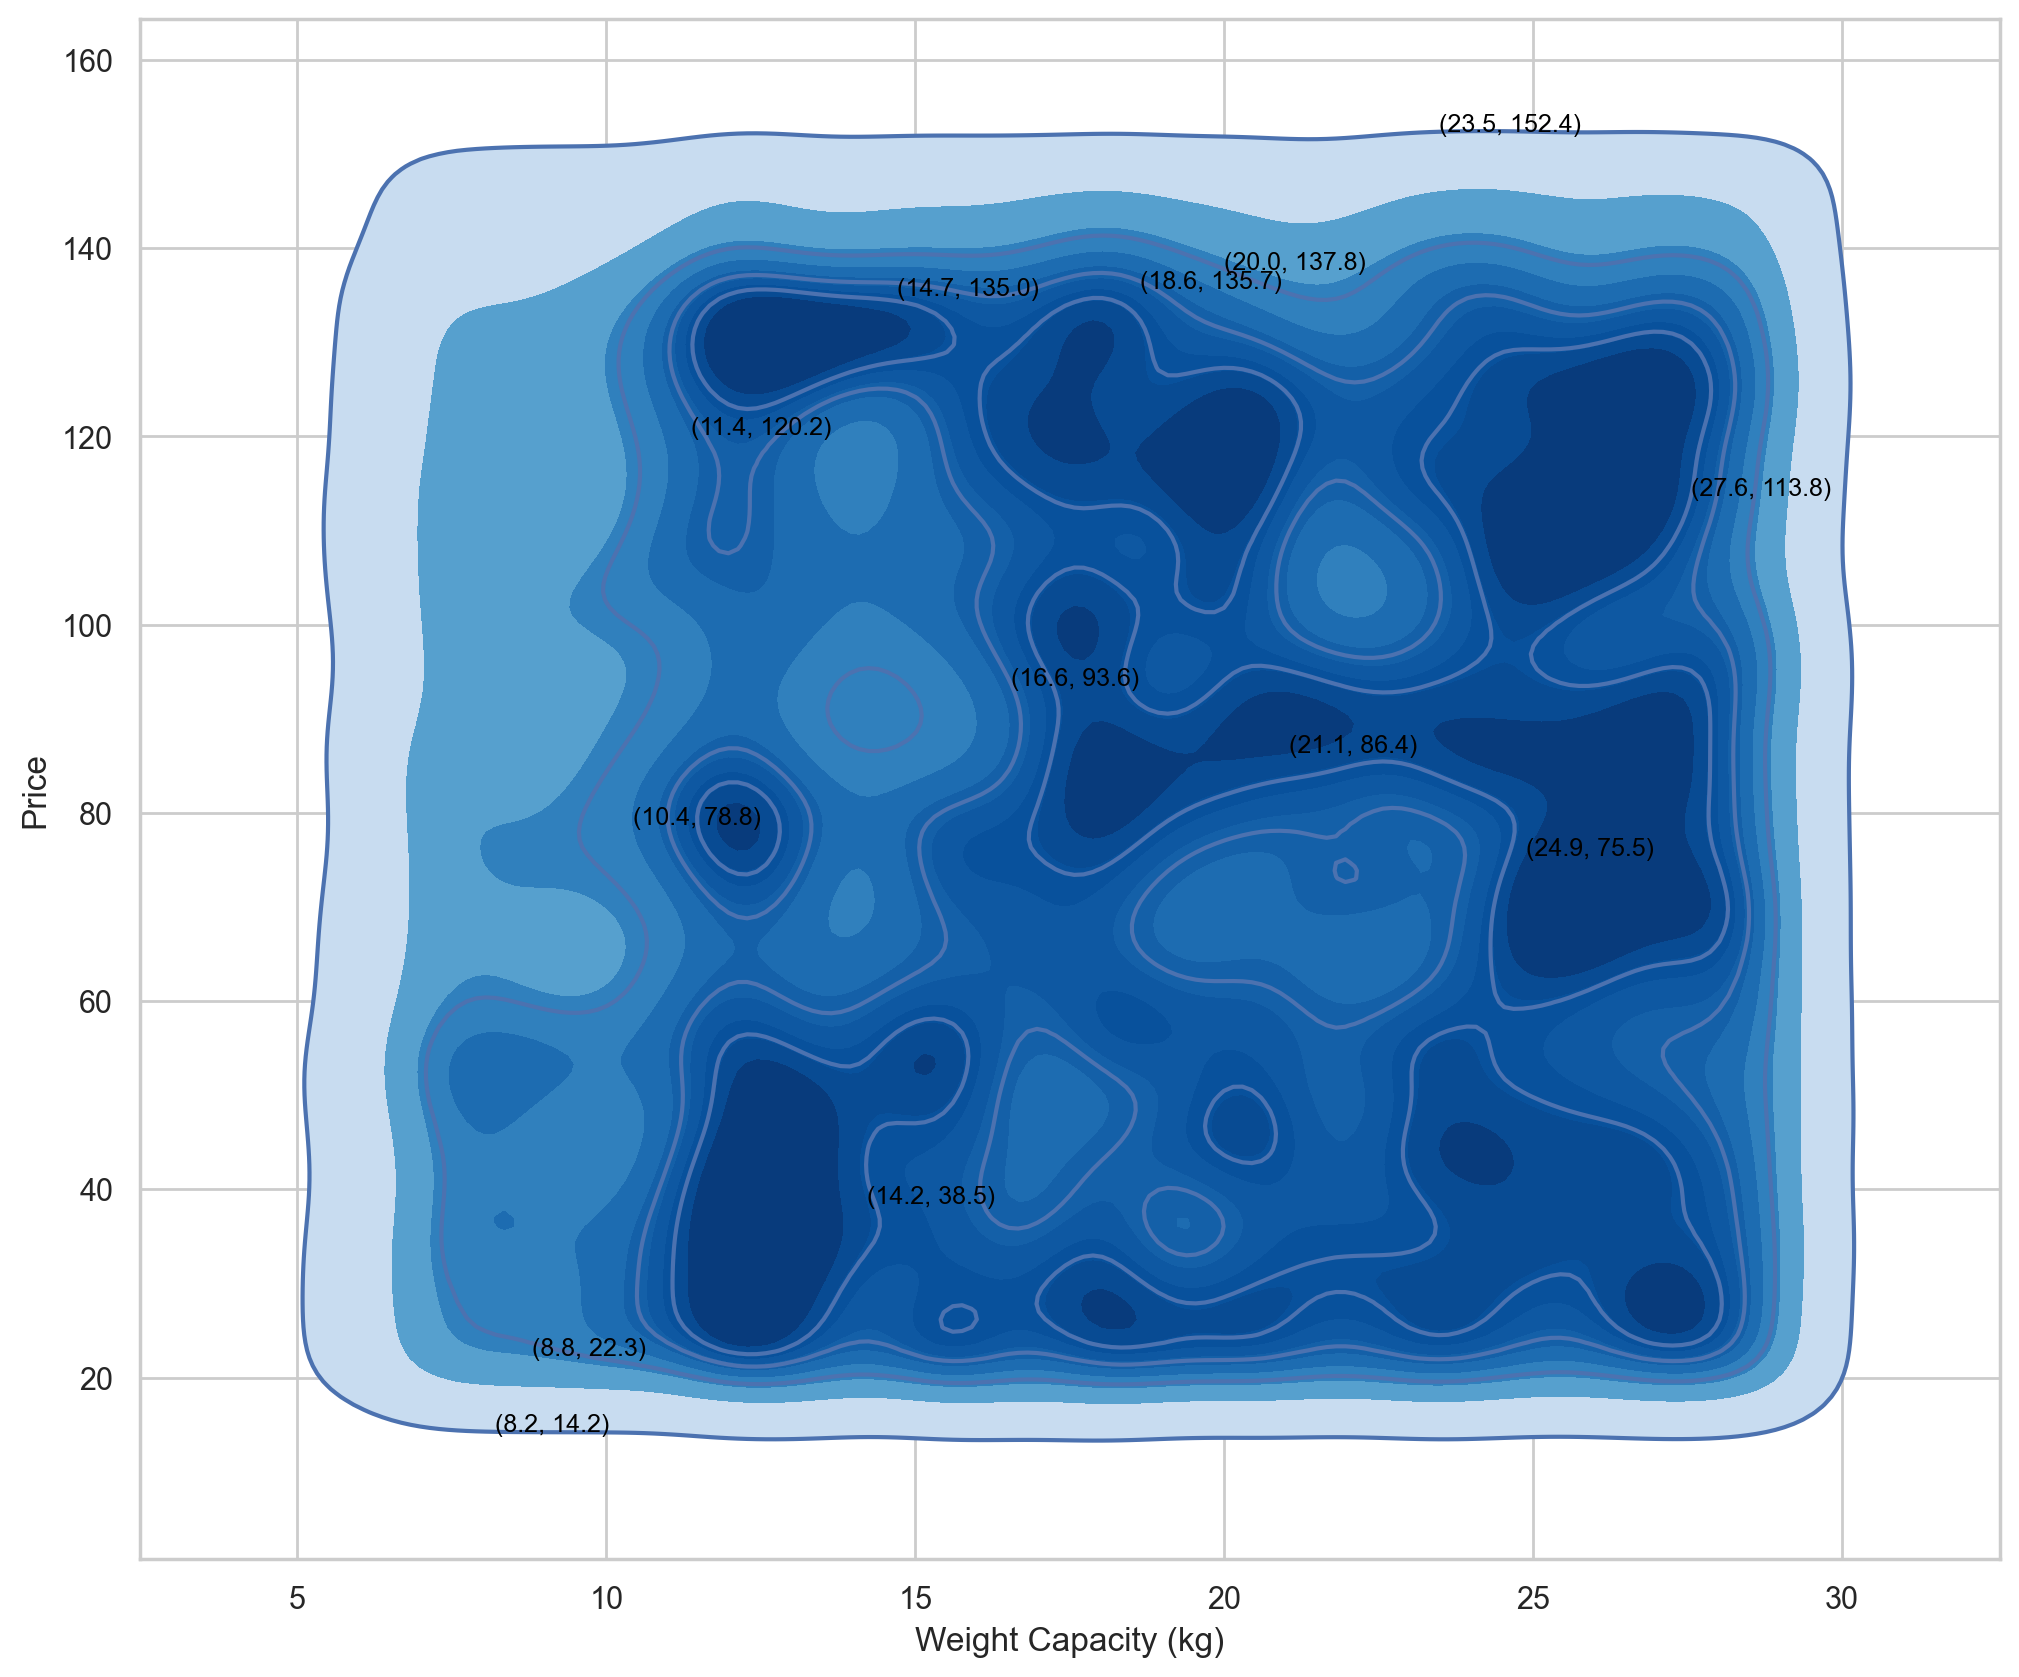

In [11]:
discrete_columns = ['Compartments', 'Weight Capacity (kg)']
plt.figure(figsize=(12, 10))
ax = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y = 'Price', fill=True, cmap='Blues', thresh=0.05, levels=10)
x_vals = train1['Weight Capacity (kg)']
y_vals = train1['Price']

kde = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y='Price', levels=5)
contours = kde.collections

for collection in contours:
  for path in collection.get_paths():
    verts=path.vertices
    if len(verts) > 0:
      x, y = verts[len(verts) // 2]
      ax.text(x, y, f"({x:.1f}, {y:.1f})", fontsize=9, color='black')

plt.show()

Weight capacity and price do seem to have some what of a correlation. On the higher side of $113-$135, weight capacities of 14.7kg, 18.6kg, 20.0kg, 27.6kg. Middle range of $75 correlates with 24.9kg. Lower range of $40 correlates with 14.2kg.

Dealing with missing Values


Top indicators of price: size, numnber of compartments, brand, material, color, weight capacity.

In [12]:
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test')
], axis=1))

Missing Values:


,train,test
Brand,9705.0,6227.0
Material,8347.0,5613.0
Size,6595.0,4381.0
Compartments,0.0,0.0
Laptop Compartment,7444.0,4962.0
Waterproof,7050.0,4811.0
Style,7970.0,5153.0
Color,9950.0,6785.0
Weight Capacity (kg),138.0,77.0
Price,0.0,NaN


In [13]:
train1.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [14]:
train1['Waterproof'] = train1['Waterproof'].replace({'Yes': 1, 'No': 0})
train1['Laptop Compartment'] = train1['Laptop Compartment'].replace({'Yes': 1, 'No': 0})
train1['Size'] = train1['Size'].replace({'Small': 1, 'Medium': 2, 'Large': 3})
train1['Style'] = train1['Style'].replace({'Tote': 1, 'Backpack': 2, 'Messenger': 3})
train1['Brand'] = train1['Brand'].replace({'Adidas': 1, 'Jansport': 2, 'Nike': 3, 'Puma': 4, 'Under Armour': 5})
train1['Material'] = train1['Material'].replace({'Canvas': 1, 'Leather': 2, 'Nylon': 3, 'Polyester': 4})
train1['Color'] = train1['Color'].replace({'Black': 1, 'Blue': 2, 'Gray': 3, 'Green': 4, 'Pink': 5, 'Red': 6})

In [15]:
test['Waterproof'] = test['Waterproof'].replace({'Yes': 1, 'No': 0})
test['Laptop Compartment'] = test['Laptop Compartment'].replace({'Yes': 1, 'No': 0})
test['Size'] = test['Size'].replace({'Small': 1, 'Medium': 2, 'Large': 3})
test['Style'] = test['Style'].replace({'Tote': 1, 'Backpack': 2, 'Messenger': 3})
test['Brand'] = test['Brand'].replace({'Adidas': 1, 'Jansport': 2, 'Nike': 3, 'Puma': 4, 'Under Armour': 5})
test['Material'] = test['Material'].replace({'Canvas': 1, 'Leather': 2, 'Nylon': 3, 'Polyester': 4})
test['Color'] = test['Color'].replace({'Black': 1, 'Blue': 2, 'Gray': 3, 'Green': 4, 'Pink': 5, 'Red': 6})

In [16]:
train_test['Waterproof'] = train_test['Waterproof'].replace({'Yes': 1, 'No': 0})
train_test['Laptop Compartment'] = train_test['Laptop Compartment'].replace({'Yes': 1, 'No': 0})
train_test['Size'] = train_test['Size'].replace({'Small': 1, 'Medium': 2, 'Large': 3})
train_test['Style'] = train_test['Style'].replace({'Tote': 1, 'Backpack': 2, 'Messenger': 3})
train_test['Brand'] = train_test['Brand'].replace({'Adidas': 1, 'Jansport': 2, 'Nike': 3, 'Puma': 4, 'Under Armour': 5})
train_test['Material'] = train_test['Material'].replace({'Canvas': 1, 'Leather': 2, 'Nylon': 3, 'Polyester': 4})
train_test['Color'] = train_test['Color'].replace({'Black': 1, 'Blue': 2, 'Gray': 3, 'Green': 4, 'Pink': 5, 'Red': 6})

Watetproof: 1: yes, 0: no
Laptop Compartment: 1: yes, 0: no
Size: 1: small, 2: medium, 3: large
Style: 1: tote, 2: backpack, 3: messenger
Brand: 1: adidas, 2: jansport, 3: nike, 4: puma, 5: under armour
Material: 1: canvas, 2: leather, 3: nylon, 4: polyester
Color: 1: black, 2: blue, 3: gra, 4: green, 5: pink, 6: red

Converting categorical features to numerical

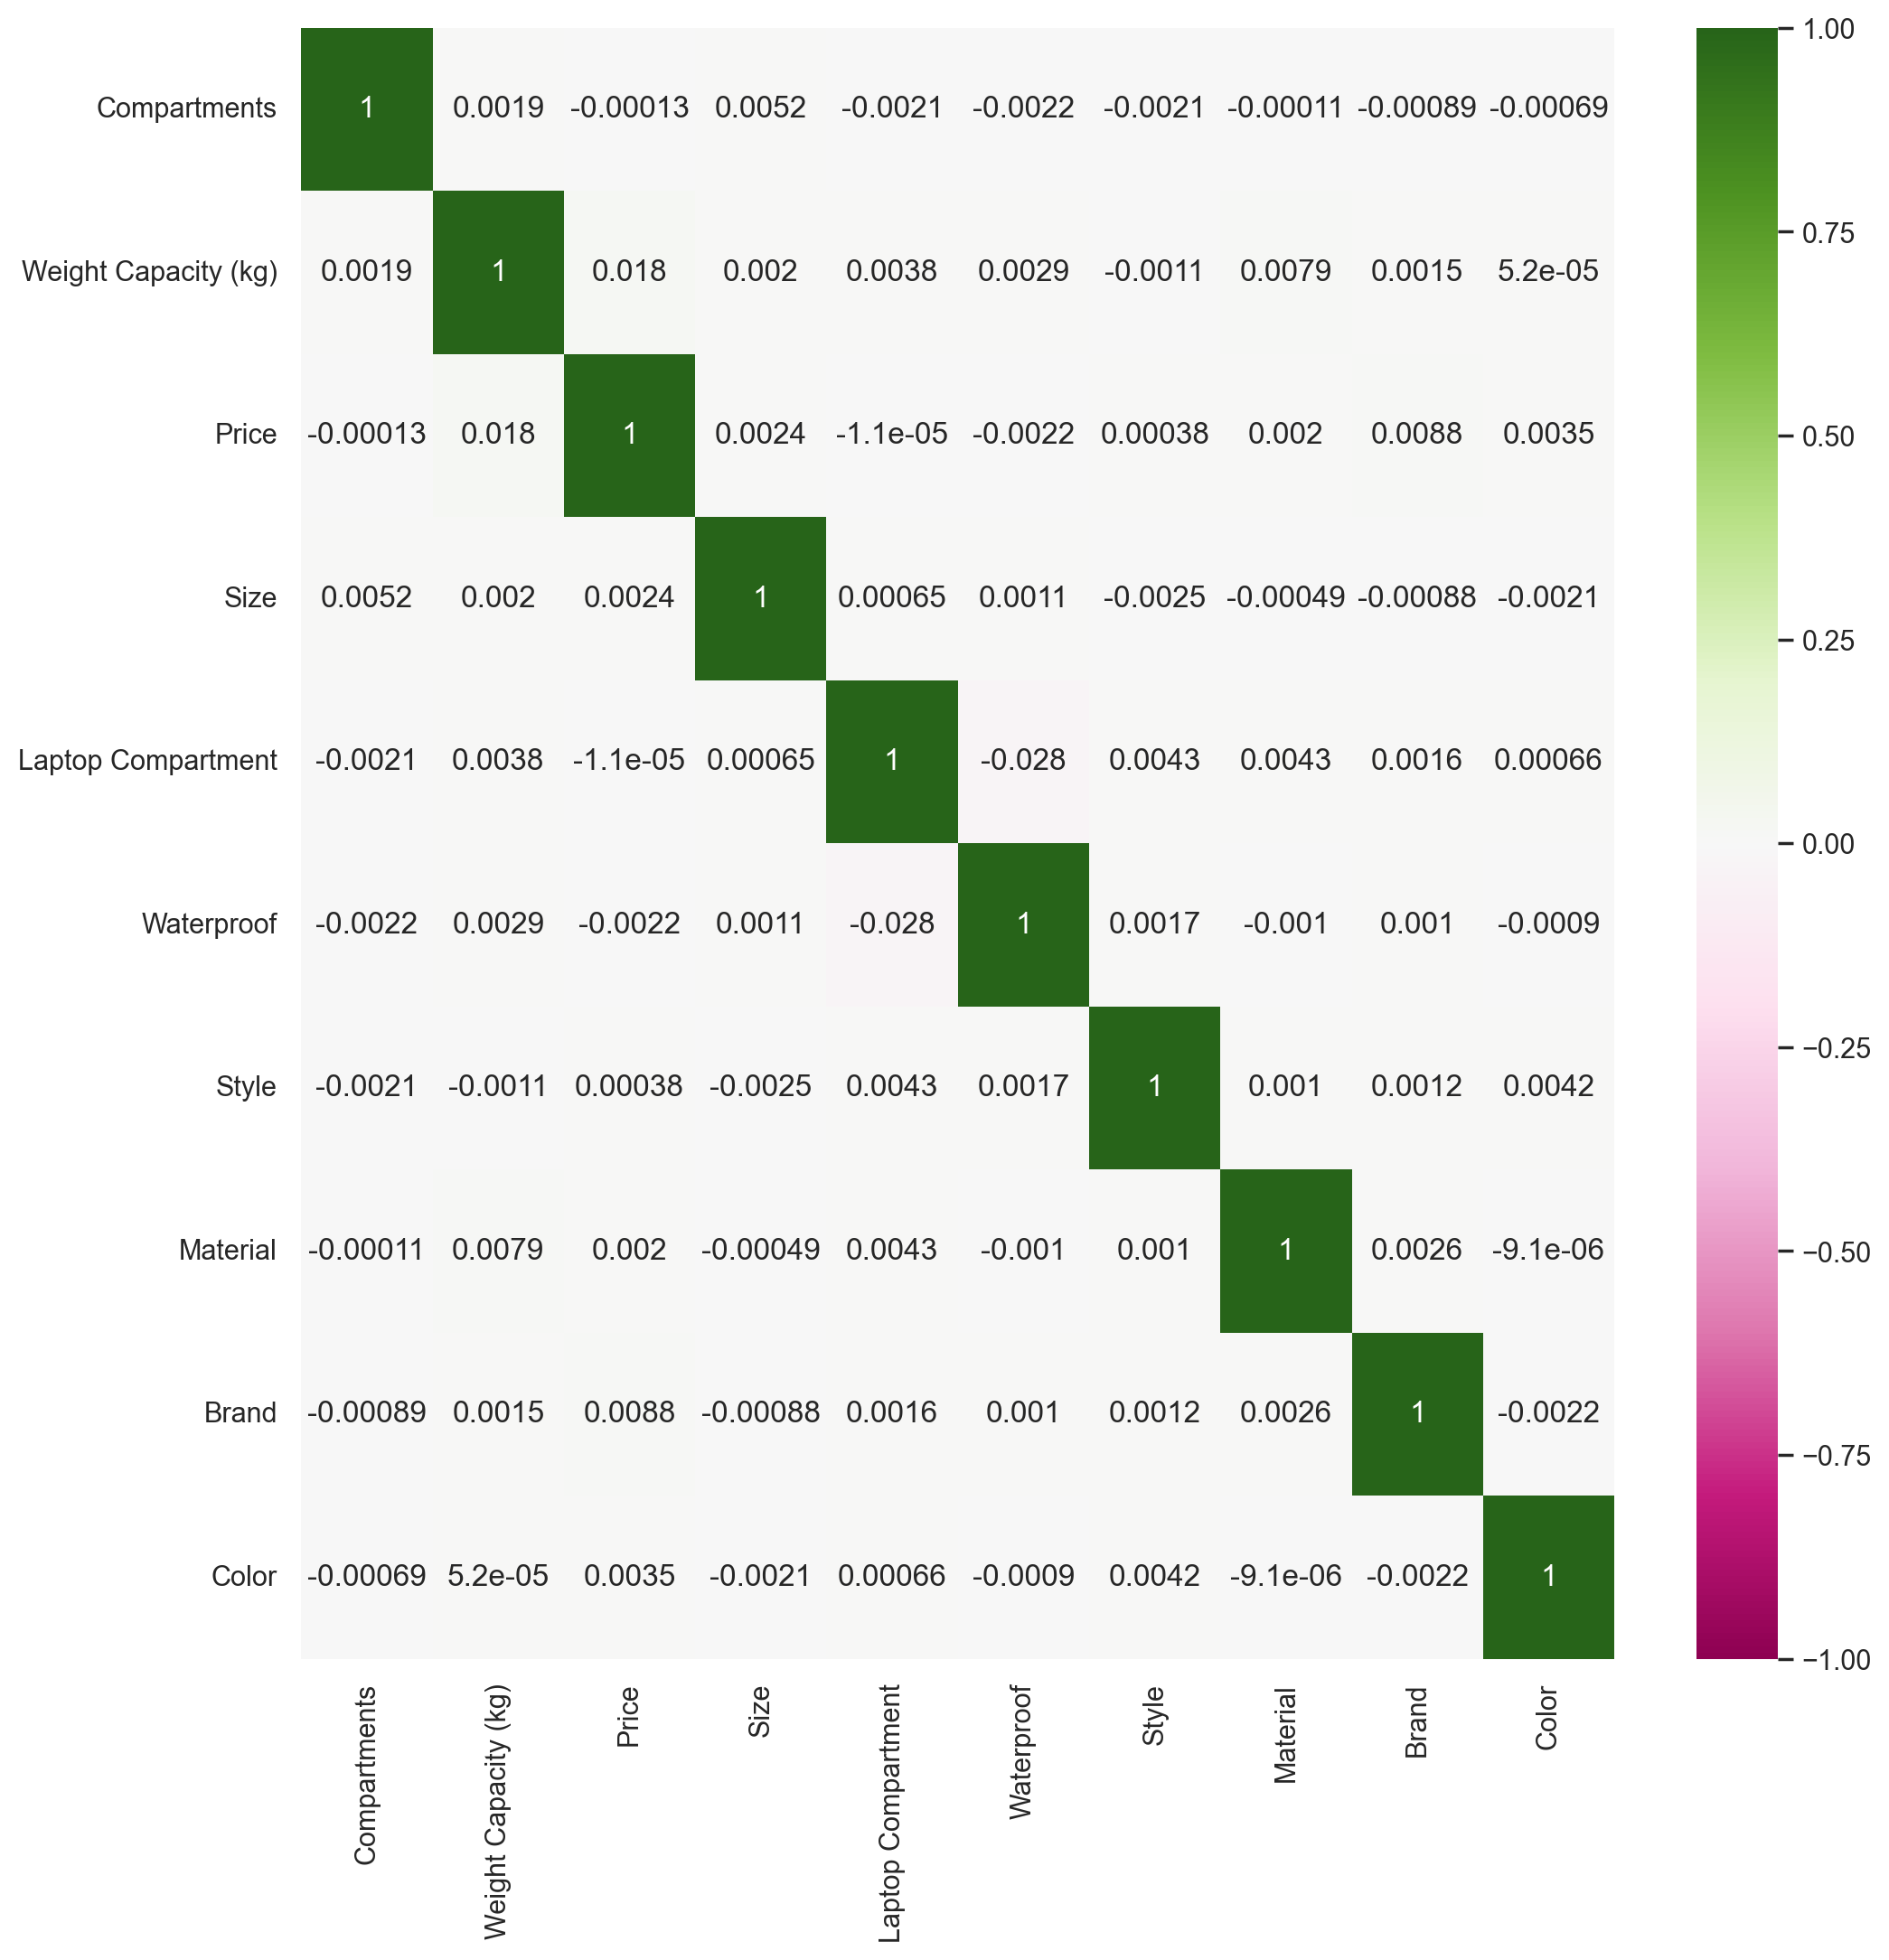

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(11, 11))
sns.heatmap(train_test[['Compartments', 'Weight Capacity (kg)', 'Price', 'Size','Laptop Compartment', 'Waterproof', 'Style', 'Material', 'Brand', 'Color']].corr(), cmap='PiYG', annot=True, vmin=-1, ax=axes)
plt.tight_layout()

Nothing is super strongly correlated. There is some slight correlations.

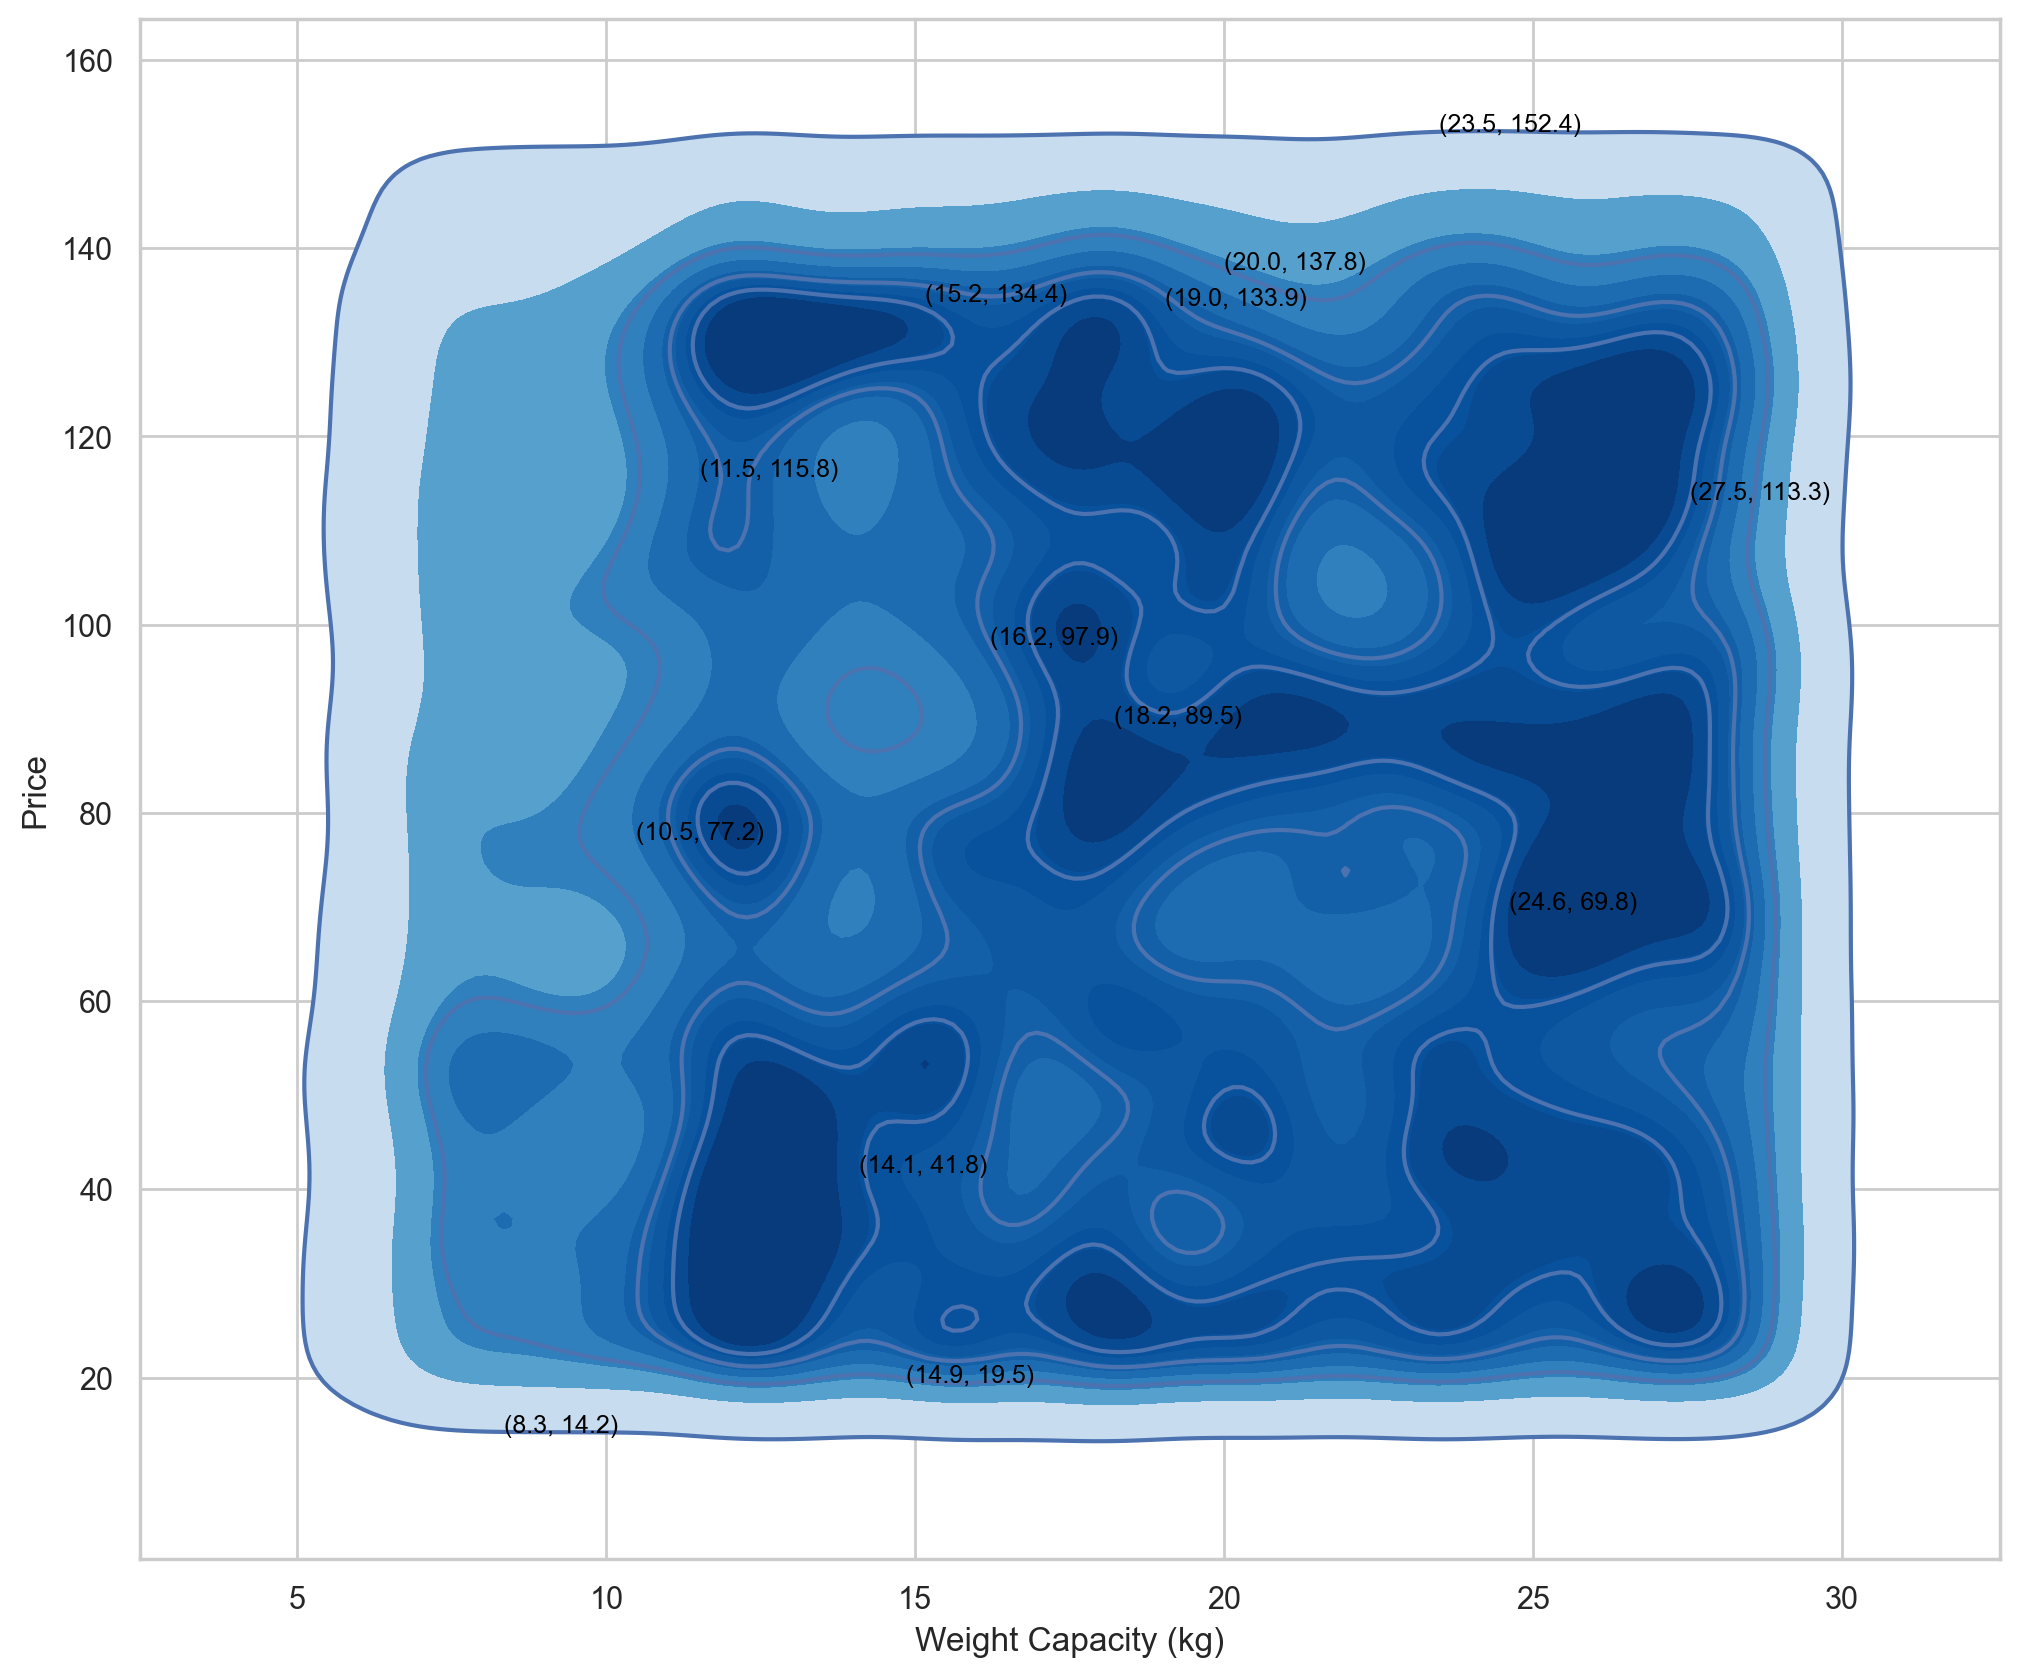

In [18]:
for df in (train1, test, train_test):
  df['Weight Capacity before Filling (kg)'] = df['Weight Capacity (kg)'].copy()
  for i, row in df[df['Weight Capacity (kg)'].isna()].iterrows():
    similar_subset = train_test[~train_test['Weight Capacity (kg)'].isna()]
    for correlated_col in ['Compartments', 'Size', 'Laptop Compartment', 'Material', 'Brand']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Weight Capacity (kg)'] = similar_subset['Weight Capacity (kg)'].median()

plt.figure(figsize=(12, 10))
ax = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y = 'Price', fill=True, cmap='Blues', thresh=0.05, levels=10)
x_vals = train1['Weight Capacity (kg)']
y_vals = train1['Price']

kde = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y='Price', levels=5)
contours = kde.collections

for collection in contours:
  for path in collection.get_paths():
    verts=path.vertices
    if len(verts) > 0:
      x, y = verts[len(verts) // 2]
      ax.text(x, y, f"({x:.1f}, {y:.1f})", fontsize=9, color='black')

plt.show()

In [19]:
for df in (train1, test, train_test):
  df['SizeBeforeFilling'] = df['Size'].copy()
  for i, row in df[df['Size'].isna()].iterrows():
    similar_subset = train_test[~train_test['Size'].isna()]
    for correlated_col in ['Compartments', 'Weight Capacity (kg)', 'Laptop Compartment', 'Waterproof']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Size'] = similar_subset['Size'].mode().iloc[0]

19:12:49 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:12:50 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:12:51 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:12:51 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


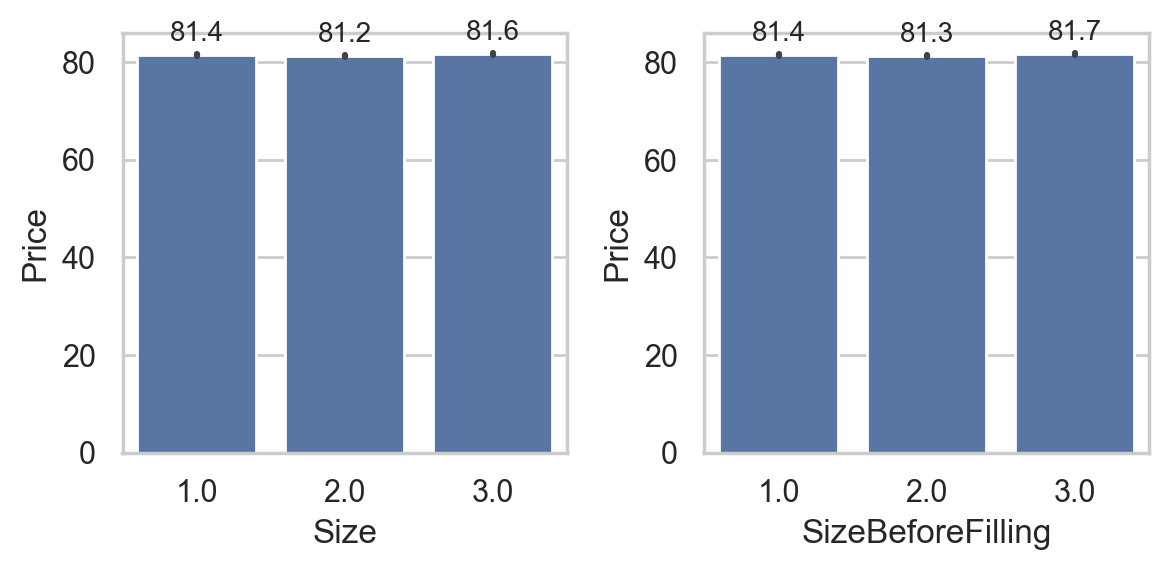

In [20]:
categorical_columns = ['Size', 'SizeBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [21]:
for df in (train1, test, train_test):
  df['LaptopCompartmentBeforeFilling'] = df['Laptop Compartment'].copy()
  for i, row in df[df['Laptop Compartment'].isna()].iterrows():
    similar_subset = train_test[~train_test['Laptop Compartment'].isna()]
    for correlated_col in ['Weight Capacity (kg)', 'Size', 'Waterproof', 'Style', 'Material', 'Brand', 'Color']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Laptop Compartment'] = similar_subset['Laptop Compartment'].mode().iloc[0]

19:24:18 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:24:18 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:24:19 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:24:20 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


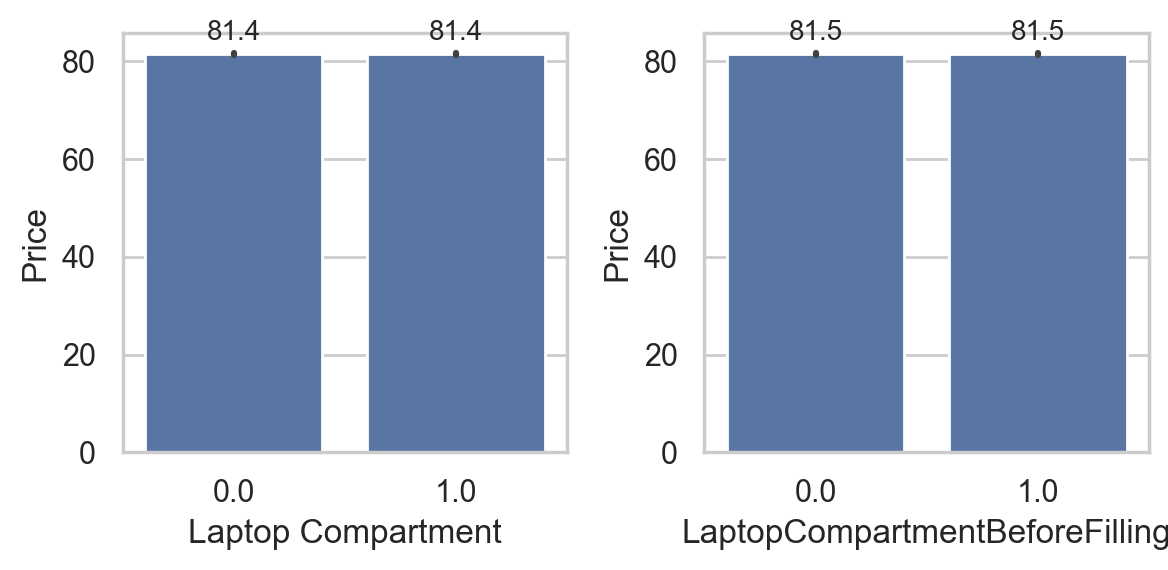

In [22]:
categorical_columns = ['Laptop Compartment', 'LaptopCompartmentBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [23]:
for df in (train1, test, train_test):
  df['WaterproofBeforeFilling'] = df['Waterproof'].copy()
  for i, row in df[df['Waterproof'].isna()].iterrows():
    similar_subset = train_test[~train_test['Waterproof'].isna()]
    for correlated_col in ['Weight Capacity (kg)', 'Size', 'Style', 'Brand']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Waterproof'] = similar_subset['Waterproof'].mode().iloc[0]

19:35:23 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:35:23 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:35:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:35:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


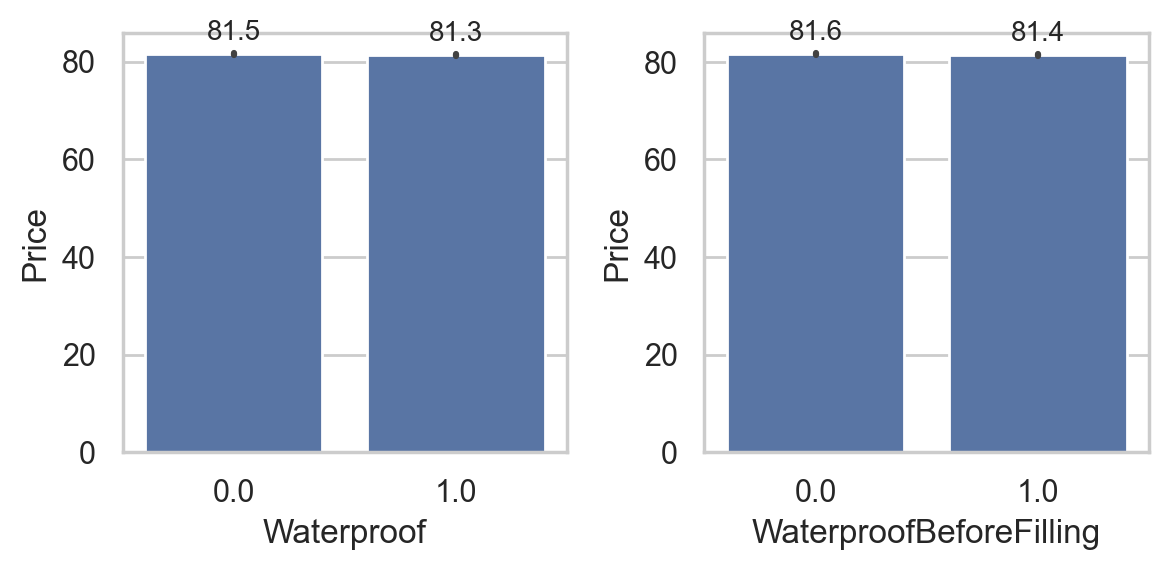

In [24]:
categorical_columns = ['Waterproof', 'WaterproofBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [25]:
for df in (train1, test, train_test):
  df['StyleBeforeFilling'] = df['Style'].copy()
  for i, row in df[df['Style'].isna()].iterrows():
    similar_subset = train_test[~train_test['Style'].isna()]
    for correlated_col in ['Laptop Compartment', 'Waterproof', 'Material', 'Brand', 'Color']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Style'] = similar_subset['Style'].mode().iloc[0]

19:57:38 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:57:38 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:57:40 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
19:57:40 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


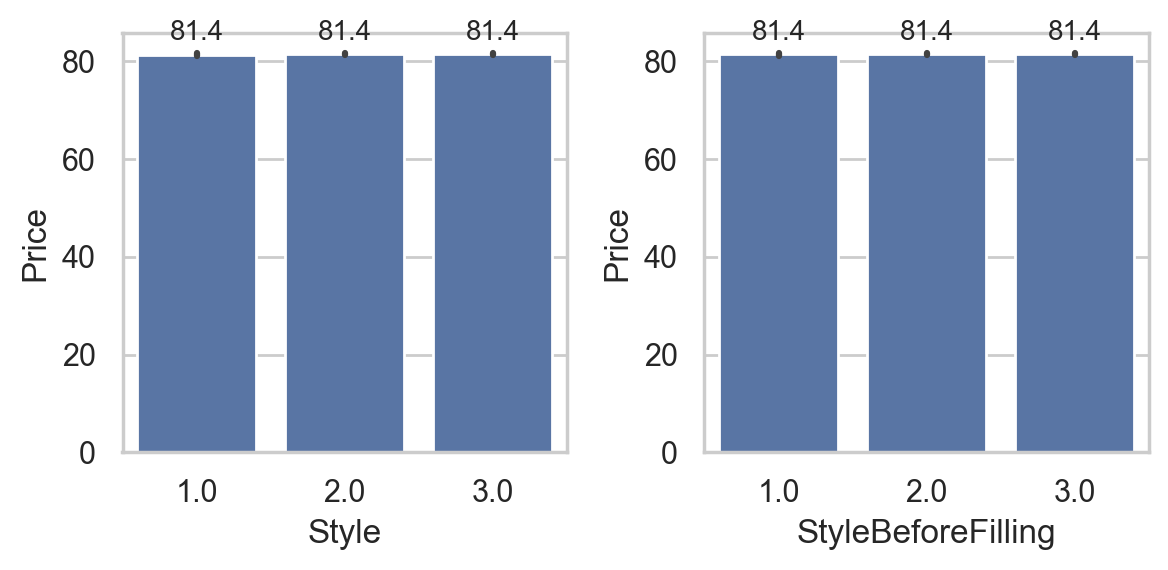

In [26]:
categorical_columns = ['Style', 'StyleBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [27]:
for df in (train1, test, train_test):
  df['MaterialBeforeFilling'] = df['Material'].copy()
  for i, row in df[df['Material'].isna()].iterrows():
    similar_subset = train_test[~train_test['Material'].isna()]
    for correlated_col in ['Weight Capacity (kg)', 'Laptop Compartment', 'Style', 'Brand']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Material'] = similar_subset['Material'].mode().iloc[0]

20:11:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:11:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:11:26 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:11:26 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


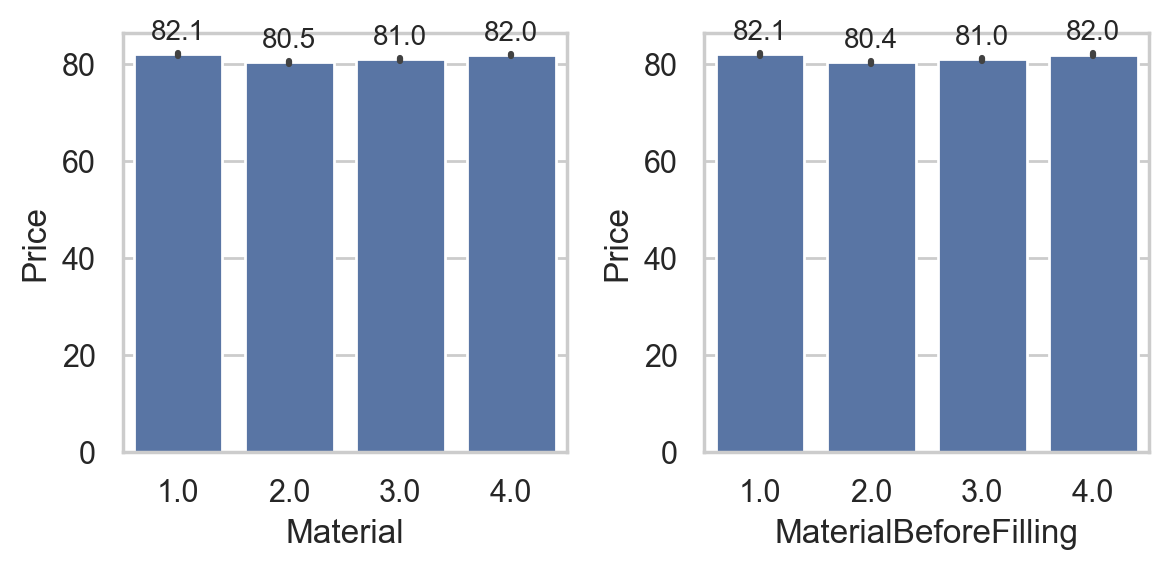

In [28]:
categorical_columns = ['Material', 'MaterialBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [29]:
for df in (train1, test, train_test):
  df['BrandBeforeFilling'] = df['Brand'].copy()
  for i, row in df[df['Brand'].isna()].iterrows():
    similar_subset = train_test[~train_test['Brand'].isna()]
    for correlated_col in ['Weight Capacity (kg)', 'Laptop Compartment', 'Waterproof', 'Style', 'Material']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Brand'] = similar_subset['Brand'].mode().iloc[0]

20:27:23 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:27:24 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:27:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:27:25 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


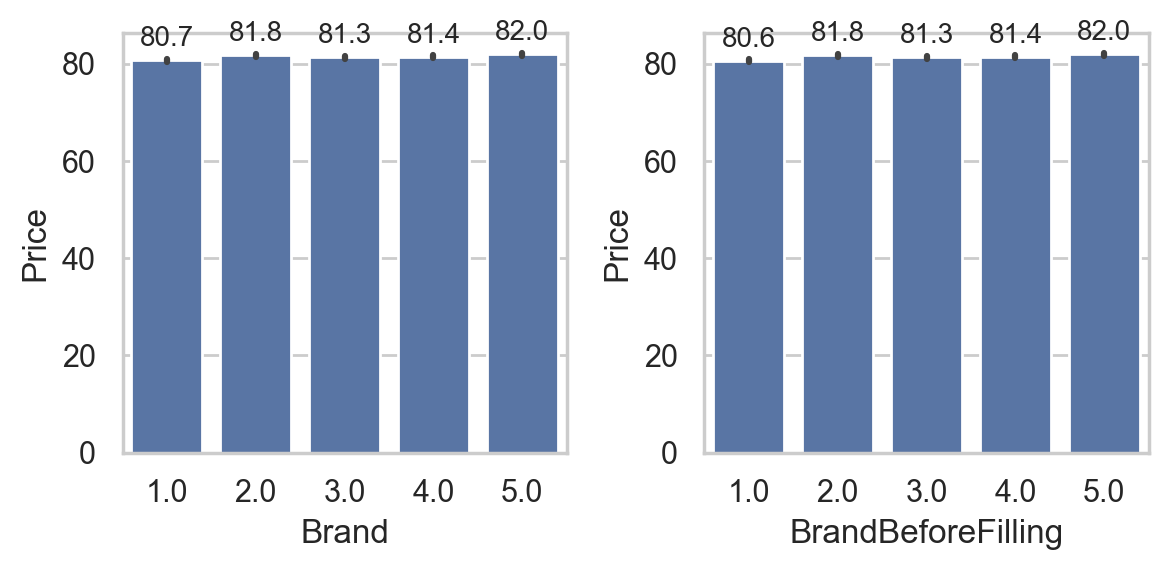

In [30]:
categorical_columns = ['Brand', 'BrandBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [31]:
for df in (train1, test, train_test):
  df['ColorBeforeFilling'] = df['Color'].copy()
  for i, row in df[df['Color'].isna()].iterrows():
    similar_subset = train_test[~train_test['Color'].isna()]
    for correlated_col in ['Weight Capacity (kg)', 'Laptop Compartment', 'Style']:
      idx_value_match = similar_subset[correlated_col] == row[correlated_col]
      if idx_value_match.sum() < 5:
        break
      similar_subset = similar_subset[idx_value_match]
    df.loc[i, 'Color'] = similar_subset['Color'].mode().iloc[0]

20:44:40 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:44:41 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:44:42 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20:44:42 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


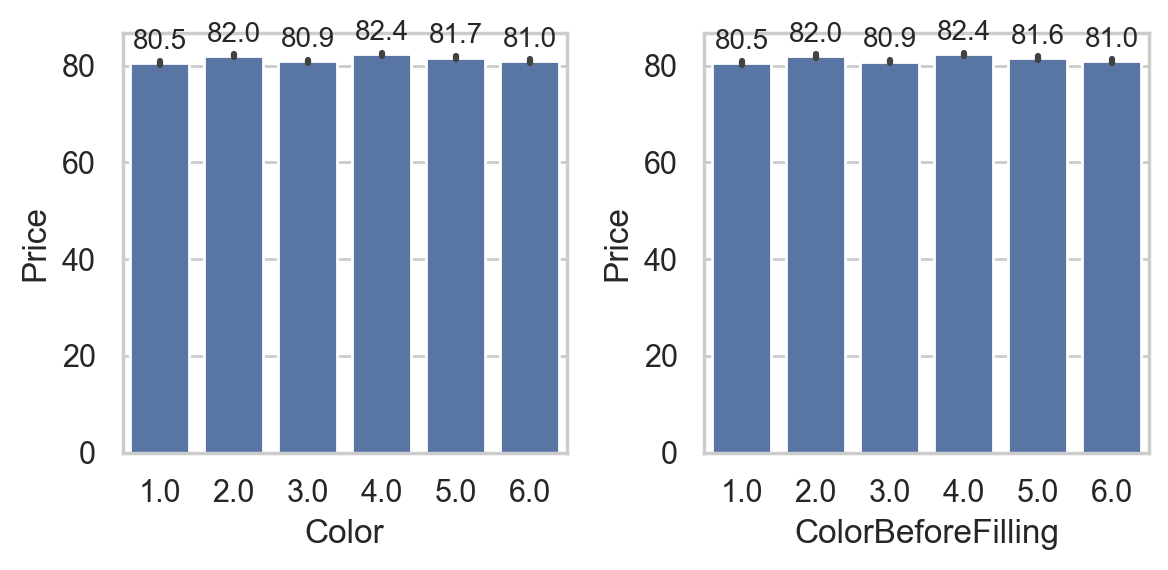

In [32]:
categorical_columns = ['Color', 'ColorBeforeFilling']

fig, axes = plt.subplots(1,2,figsize=(6, 3))
for i, categorical_column in enumerate(categorical_columns):
  ax = axes[i]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

In [33]:
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test')
], axis=1))

Missing Values:


,train,test
Brand,0.0,0.0
Material,0.0,0.0
Size,0.0,0.0
Compartments,0.0,0.0
Laptop Compartment,0.0,0.0
Waterproof,0.0,0.0
Style,0.0,0.0
Color,0.0,0.0
Weight Capacity (kg),0.0,0.0
Price,0.0,NaN


In [34]:
to_drop = ['Weight Capacity before Filling (kg)', 'SizeBeforeFilling', 'SizeBeforeFilling', 'WaterproofBeforeFilling', 'StyleBeforeFilling', 'MaterialBeforeFilling', 'BrandBeforeFilling', 'ColorBeforeFilling']

for df in (train1, test, train_test):
  df.drop(to_drop, axis=1, inplace=True)

In [36]:
to_drop = ['LaptopCompartmentBeforeFilling']
for df in (train1, test, train_test):
  df.drop(to_drop, axis=1, inplace=True)

In [40]:
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test'),
  train_test.iloc[:, 1:].isna().sum().rename('train_test')
], axis=1))

Missing Values:


,train,test,train_test
Brand,0.0,0.0,0.0
Material,0.0,0.0,0.0
Size,0.0,0.0,0.0
Compartments,0.0,0.0,0.0
Laptop Compartment,0.0,0.0,0.0
Waterproof,0.0,0.0,0.0
Style,0.0,0.0,0.0
Color,0.0,0.0,0.0
Weight Capacity (kg),0.0,0.0,0.0
Price,0.0,NaN,200000.0


In [41]:
df = pd.DataFrame(train1)
df.to_csv('train_no_missing_values.csv', index=False)

In [43]:
df = pd.DataFrame(test)
df.to_csv('test_no_missing_values.csv', index=False)

In [44]:
df = pd.DataFrame(train_test)
df.to_csv('train_test_no_missing_values.csv', index=False)

In [45]:
train1_cleaned = pd.read_csv('data/train_no_missing_values.csv')
test_cleaned = pd.read_csv('data/test_no_missing_values.csv')
train_test_cleaned = pd.read_csv('data/train_test_no_missing_values.csv')

Bags that cost the most? are there similar features between them? Like a polyester waterproof backpack or a leather tote?